### 트렌드 예측
- 선형 회귀 모델을 사용하여 트렌드를 학습하고 예측합니다.
- 예측된 트렌드와 실제 데이터를 시각화하여 비교합니다.

### 잔차 모델링
- 트렌드 예측의 잔차를 모델링하기 위해 결정트리 회귀 모델을 사용하여 잔차를 예측합니다.
- 초기 트렌드 예측과 잔차 예측 결과를 합쳐 최종 예측을 생성합니다.
- 최종 예측 및 실제 데이터를 시각화하여 비교합니다.

### 성능 평가
- 여러 모델(선형 회귀, 결정트리)을 학습하고 예측했습니다. 각 모델의 성능을 시각화합니다.
- 잔차를 별도로 모델링하고 이를 통해 최종 모델 성능을 분석합니다.

### 지연 피쳐 및 이동 평균 생성
- 새로운 지연 피쳐와 이동 평균을 생성하고 이를 사용해 최종 예측 모델을 학습합니다.
- 이전에 훈련된 모델의 지연 피쳐 및 이동 평균을 테스트 데이터에 적용하여 예측 결과를 시각화합니다.

### 모델 시각화
- 각 단계마다 생성된 예측 결과 및 실제 값을 다양한 그래프로 시각화하여 분석합니다.

이 과정은 시계열 데이터 예측의 전형적인 절차를 보여주며, 각 단계에서 시각화를 통해 모델의 성능을 직관적으로 확인할 수 있도록 돕습니다.

In [65]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

matplotlib_inline.backend_inline.set_matplotlib_formats("retina") # svg, retina, png2x ...
mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "NanumSquareRound")
plt.rcParams["axes.unicode_minus"] = False

In [66]:
def drawing_graph(X,pt,xt,tt,xt2):
    fig, ax = plt.subplots(1,1, figsize=(12,6))

    sns.lineplot(data=X,
                 x = "Date",
                 y = "Close",
                 color="black",
                 label="실제 snp500 값",ax=ax)

    sns.lineplot(x=xt.index,
                 y=pt.flatten(),
                 color="tab:green",
                 alpha = 0.8,
                 linewidth = 3,
                 label="예측 데이터",ax=ax)
    sns.lineplot(x=xt2.index,
                 y=tt.flatten(),
                 alpha = 1,
                 color="tab:orange",
                 linewidth = 3,
                 label="예측 데이터",ax=ax)


DatetimeIndex(['2010-01-04 00:00:00+00:00', '2010-01-05 00:00:00+00:00',
               '2010-01-06 00:00:00+00:00', '2010-01-07 00:00:00+00:00',
               '2010-01-08 00:00:00+00:00', '2010-01-11 00:00:00+00:00',
               '2010-01-12 00:00:00+00:00', '2010-01-13 00:00:00+00:00',
               '2010-01-14 00:00:00+00:00', '2010-01-15 00:00:00+00:00',
               ...
               '2020-12-16 00:00:00+00:00', '2020-12-17 00:00:00+00:00',
               '2020-12-18 00:00:00+00:00', '2020-12-21 00:00:00+00:00',
               '2020-12-22 00:00:00+00:00', '2020-12-23 00:00:00+00:00',
               '2020-12-24 00:00:00+00:00', '2020-12-28 00:00:00+00:00',
               '2020-12-29 00:00:00+00:00', '2020-12-30 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=2768, freq=None)

In [84]:
import yfinance as yf
import pandas as pd

# S&P 500 데이터 가져오기
snp_500 = yf.download('AAPL', start='2010-01-01', end='2020-12-31')

snp_500=pd.DataFrame(columns=[i[0] for i in snp_500.columns],
                     data=snp_500.values,
                     index=snp_500.index)

# Close 가격만 남기고 필요한 열만 선택
close_snp = snp_500[['Close']].reset_index()

# 데이터 확인
close_snp.head()

[*********************100%***********************]  1 of 1 completed


,Date,Close
0,2010-01-04 00:00:00+00:00,7.643214
1,2010-01-05 00:00:00+00:00,7.656429
2,2010-01-06 00:00:00+00:00,7.534643
3,2010-01-07 00:00:00+00:00,7.520714
4,2010-01-08 00:00:00+00:00,7.570714


In [68]:
close_snp

,index,Close
0,0,7.643214
1,1,7.656429
2,2,7.534643
3,3,7.520714
4,4,7.570714
...,...,...
2763,2763,130.960007
2764,2764,131.970001
2765,2765,136.690002
2766,2766,134.869995


In [69]:
close_snp["index"] = close_snp.index
close_snp.set_index("Date", inplace=True)

KeyError: "None of ['Date'] are in the columns"

In [18]:
y = close_snp[["Close"]]

# 다항 Trand 피쳐 만들기
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    constant=True,  # the intercept
    order=55,        # quadratic trend
    drop=True,      # drop terms to avoid collinearity
)

X = dp.in_sample()

In [23]:
X

,const,trend,trend_squared
Date,,,
2010-01-04 00:00:00+00:00,1.0,1.0,1.0
2010-01-05 00:00:00+00:00,1.0,2.0,4.0
2010-01-06 00:00:00+00:00,1.0,3.0,9.0
2010-01-07 00:00:00+00:00,1.0,4.0,16.0
2010-01-08 00:00:00+00:00,1.0,5.0,25.0
...,...,...,...
2020-12-23 00:00:00+00:00,1.0,2764.0,7639696.0
2020-12-24 00:00:00+00:00,1.0,2765.0,7645225.0
2020-12-28 00:00:00+00:00,1.0,2766.0,7650756.0


In [20]:
x_train, x_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.4,
                                                    shuffle=False)

In [21]:
trend_pred_train

array([[ 7.13056823],
       [ 7.14887201],
       [ 7.16716933],
       ...,
       [28.59284538],
       [28.60044012],
       [28.6080284 ]])

['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

ValueError: Data must be 1-dimensional, got ndarray of shape (2768, 1) instead

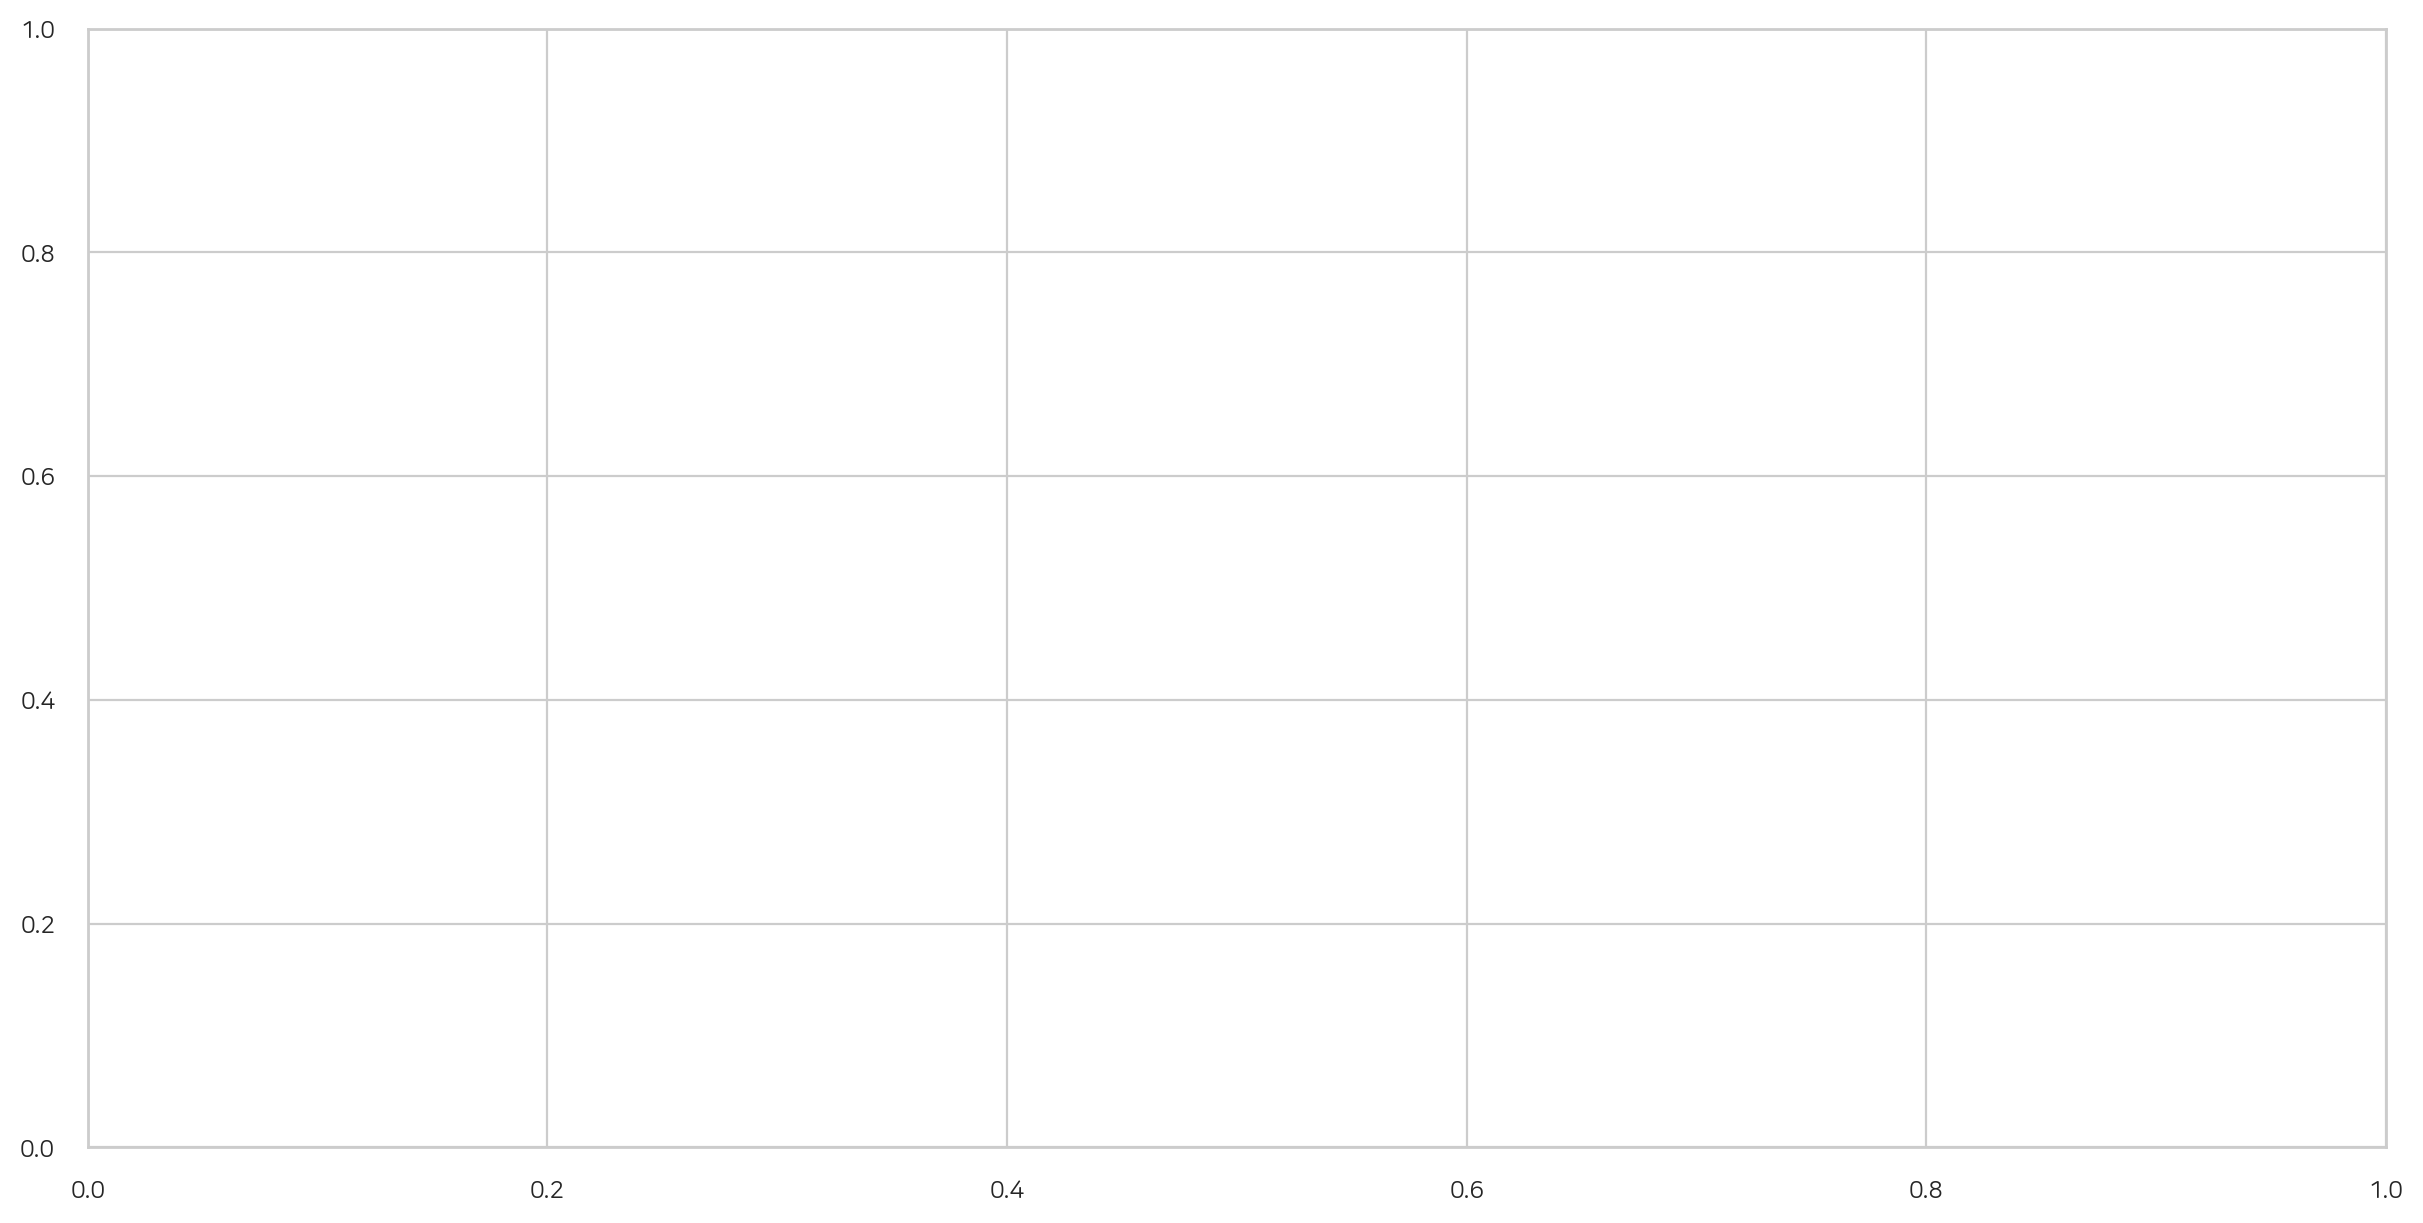

In [22]:
# 1 트렌드 학습하기
model_trend = LinearRegression()
model_trend.fit(x_train, y_train)
trend_pred_train = model_trend.predict(x_train)
trend_pred_test = model_trend.predict(x_test)
drawing_graph(snp_500,trend_pred_train,x_train,trend_pred_test,x_test)

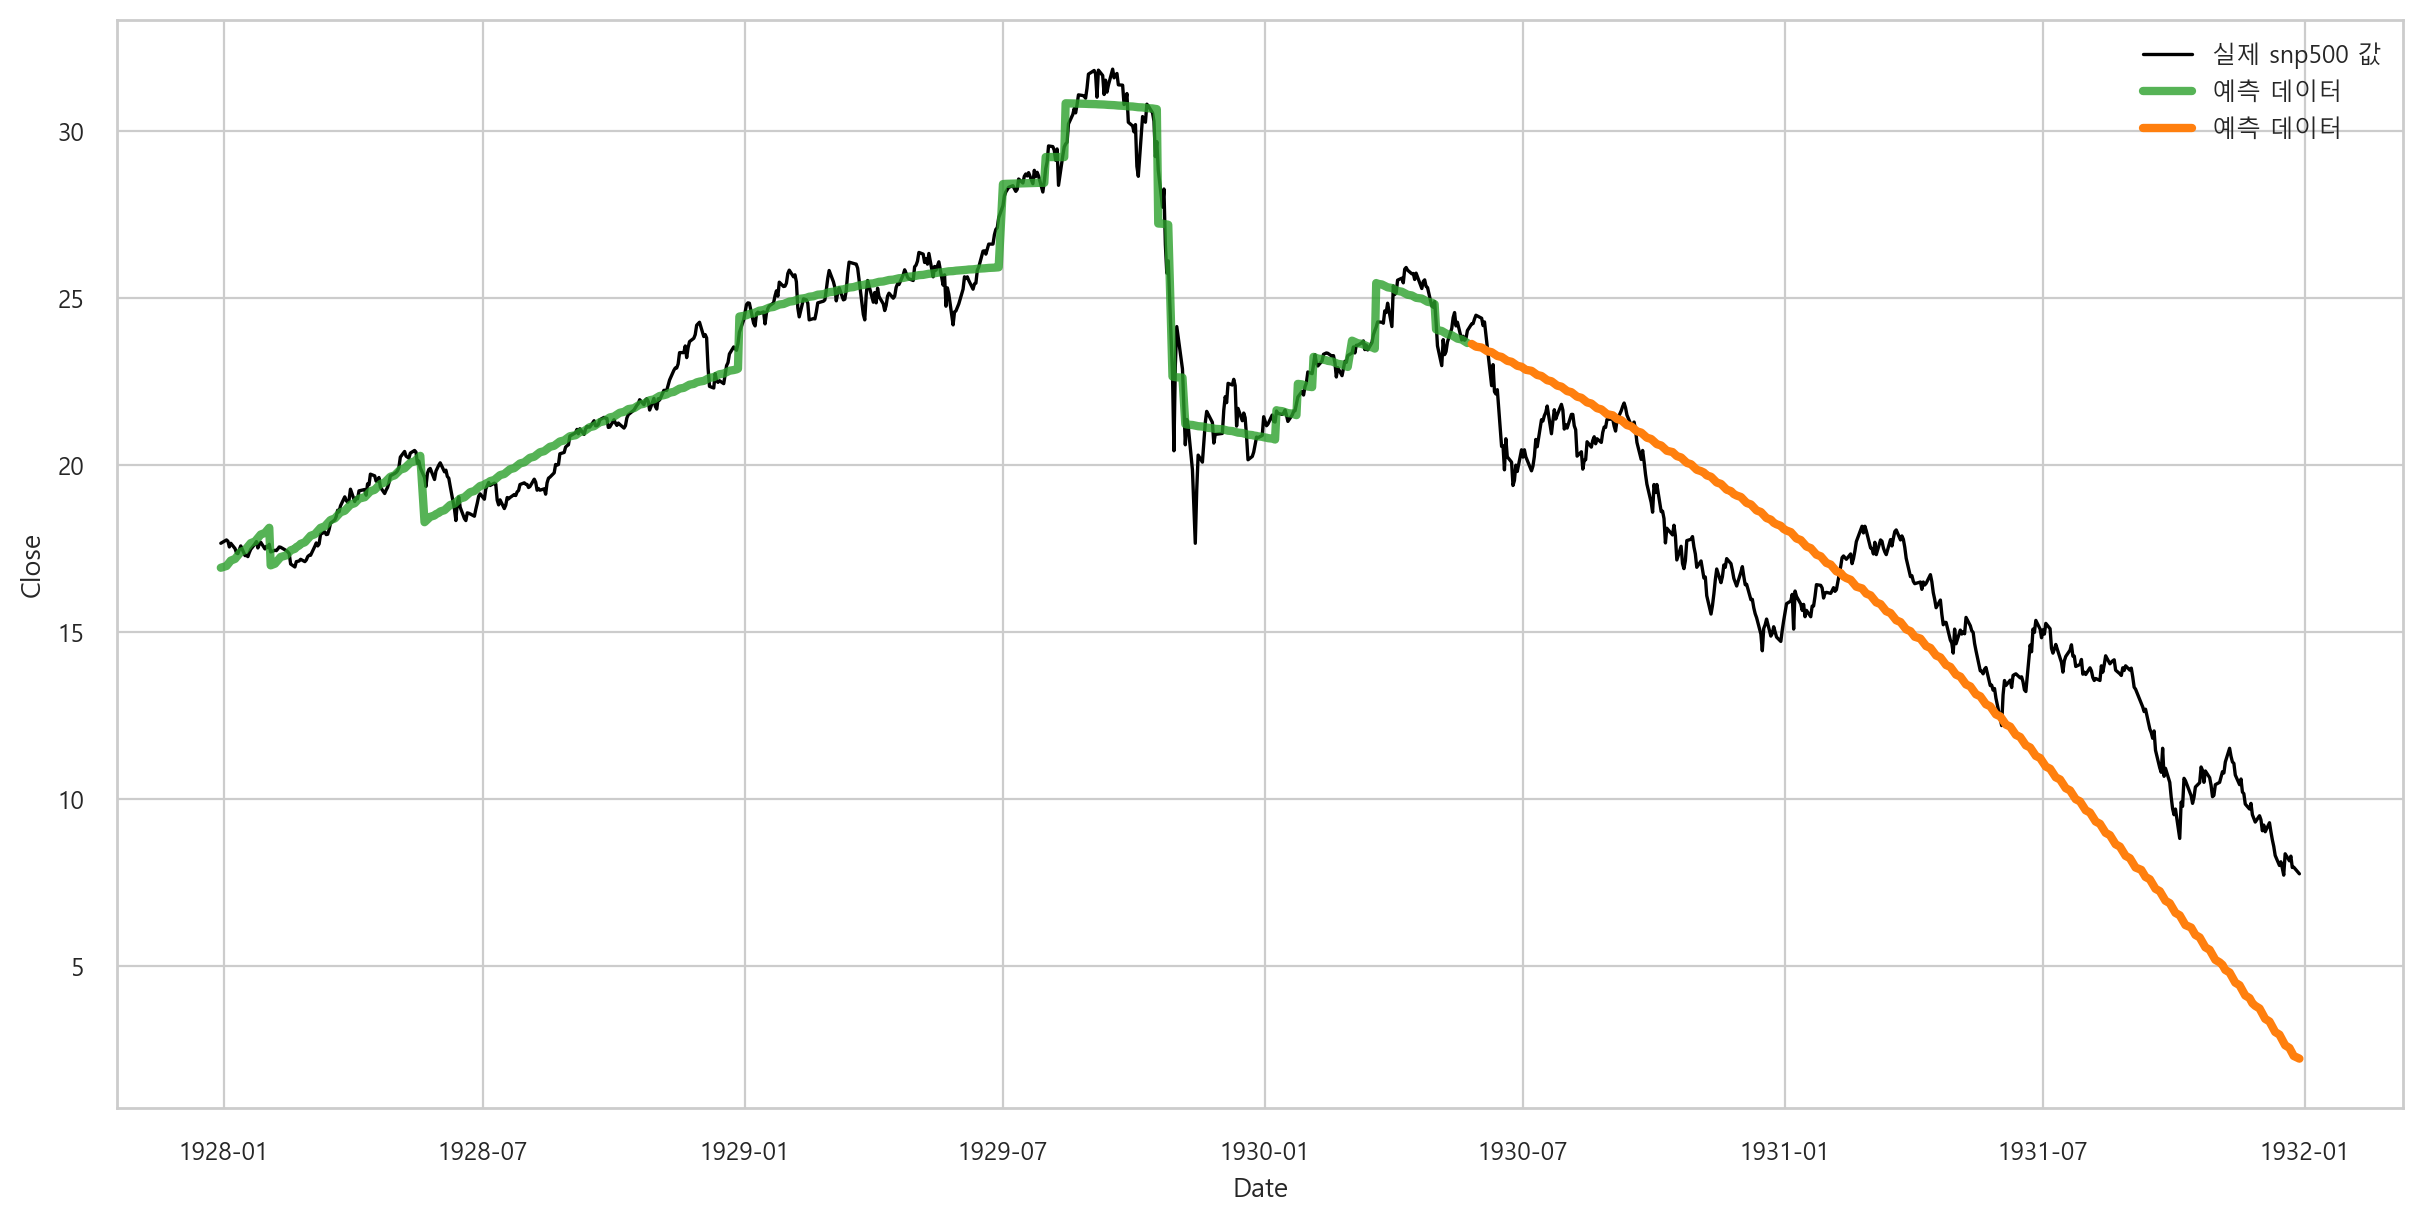

In [421]:
resid_train = y_train - trend_pred_train
model_tree = DecisionTreeRegressor(max_depth=4)
model_tree.fit(x_train,resid_train)
pred_fin_train = model_tree.predict(x_train) + trend_pred_train.reshape(len(x_train),)
pred_fin_test = model_tree.predict(x_test) + trend_pred_test.reshape(len(x_test),)

drawing_graph(snp_500,pred_fin_train,x_train,pred_fin_test,x_test)

In [422]:
close_snp

model_1 = LinearRegression()
model_1.fit(x_train, y_train)
pred_train = model_1.predict(x_train)
pred_test = model_1.predict(x_test)

In [423]:
pred_train = pd.Series(pred_train.flatten(), index=y_train.index)
pred_test = pd.Series(pred_test.flatten(), index=y_test.index)

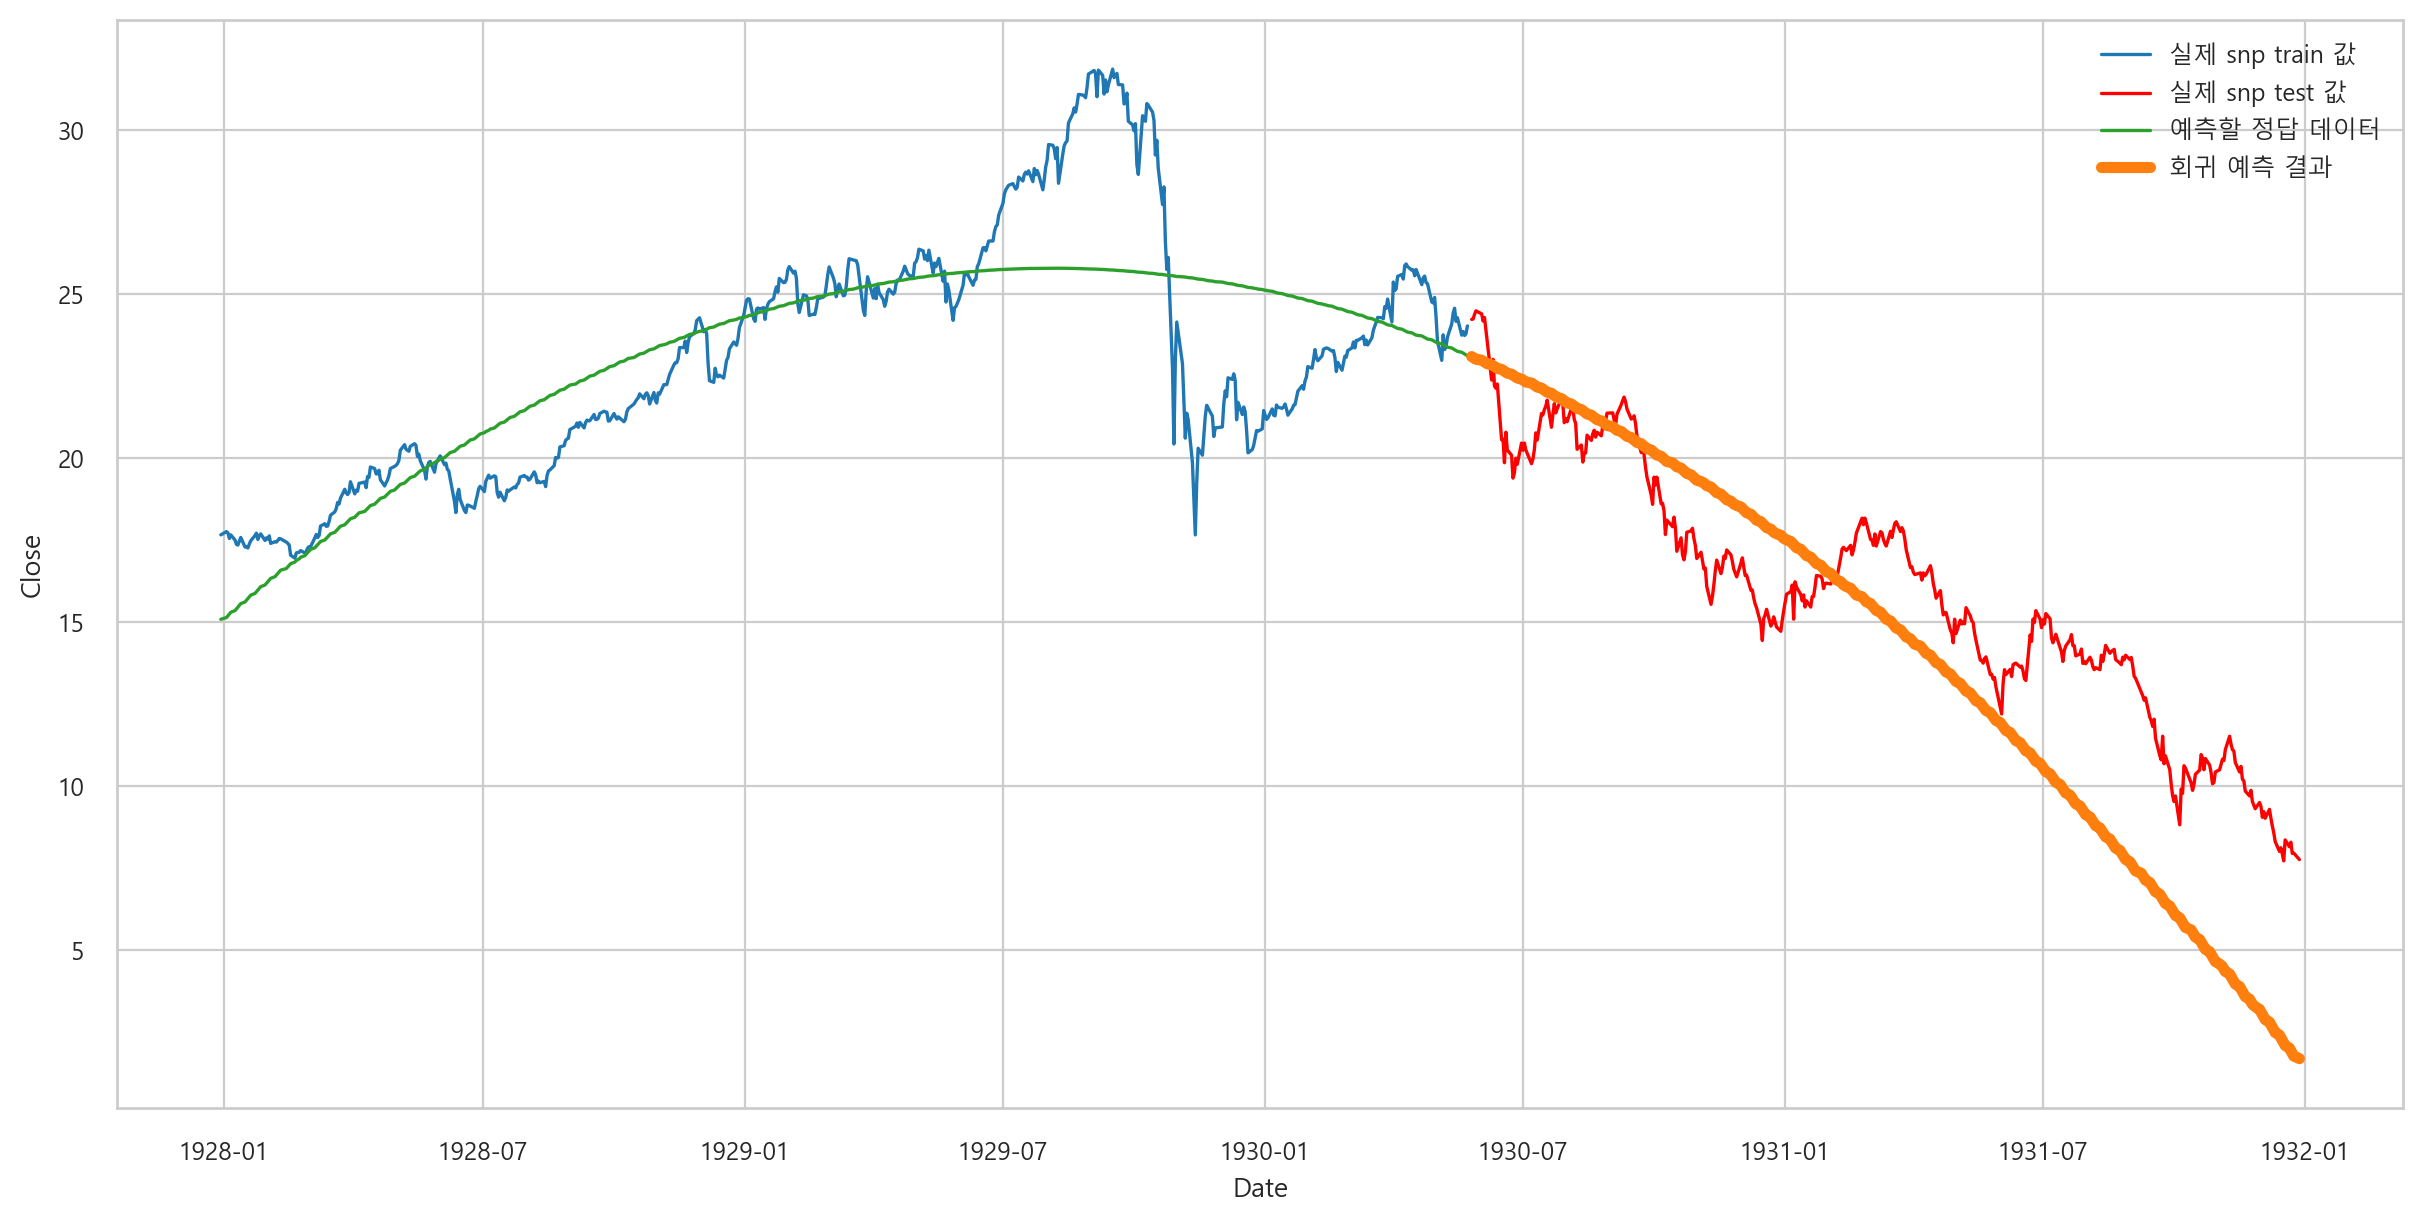

In [424]:
fig, ax = plt.subplots(1,1, figsize=(12,6))


sns.lineplot(data=y_train,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="실제 snp train 값",)

sns.lineplot(data=y_test,
             x = "Date",
             y = "Close",
             color="red",
             label="실제 snp test 값",)

sns.lineplot(x=y_train.index,
             y=pred_train,
             color="tab:green",
             label="예측할 정답 데이터",)

sns.lineplot(x=y_test.index,
             y=pred_test,
             color="tab:orange",
             linewidth=4,
             label="회귀 예측 결과",);

In [425]:
model_2 = DecisionTreeRegressor(max_depth=2)
model_2.fit(x_train, y_train)
pred_train_2 = model_2.predict(x_train)
pred_test_2 = model_2.predict(x_test)

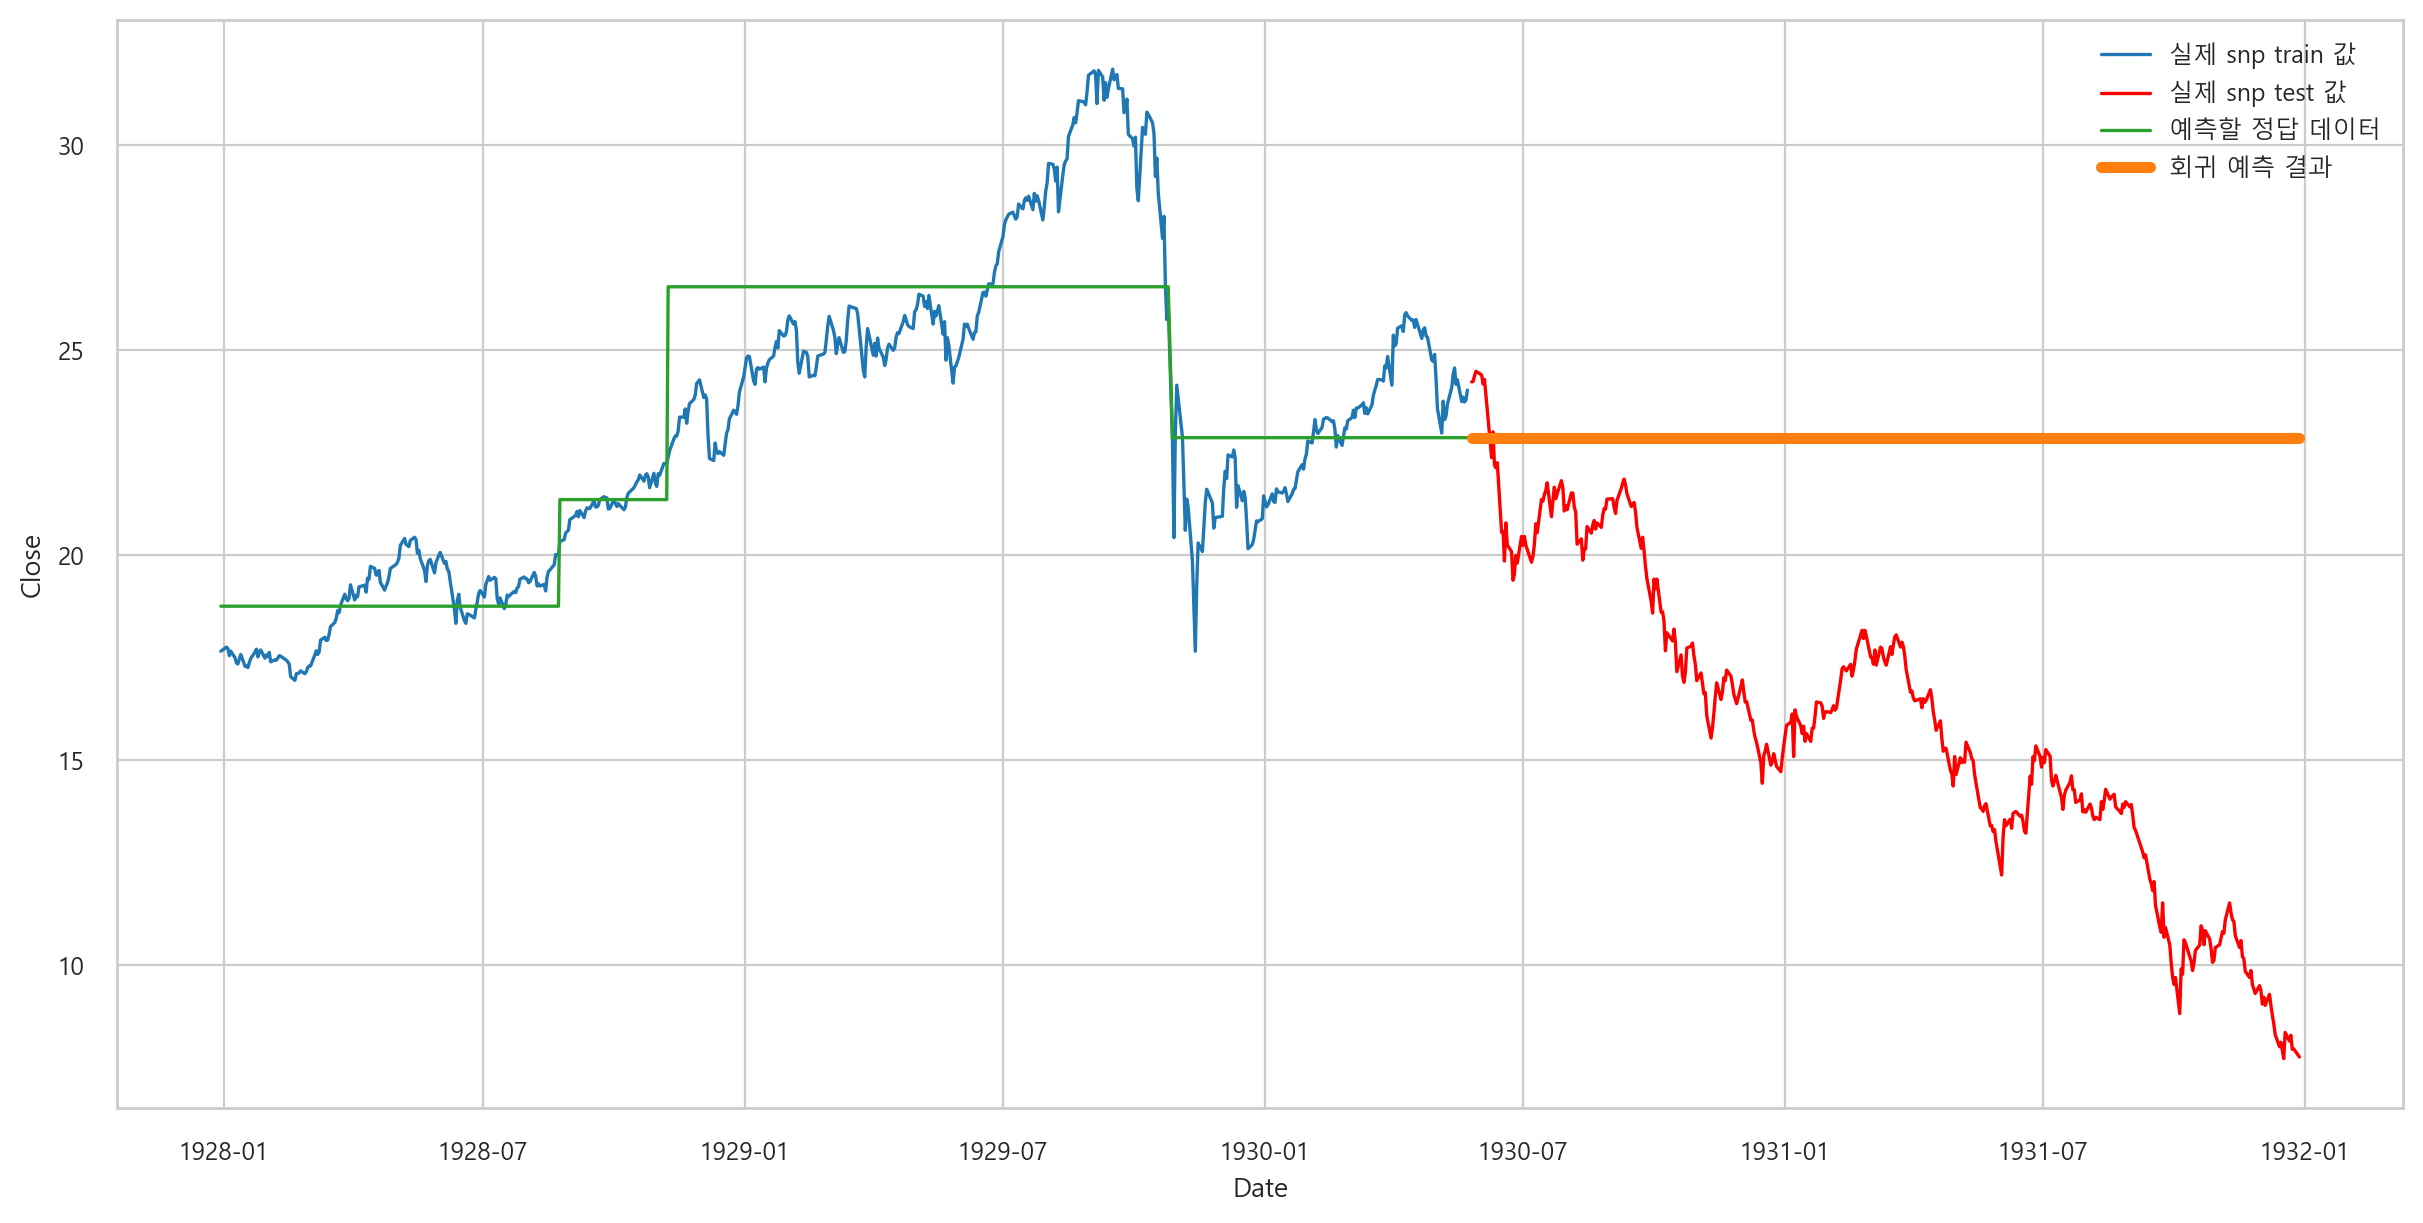

In [426]:
fig, ax = plt.subplots(1,1, figsize=(12,6))


sns.lineplot(data=y_train,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="실제 snp train 값",)

sns.lineplot(data=y_test,
             x = "Date",
             y = "Close",
             color="red",
             label="실제 snp test 값",)

sns.lineplot(x=y_train.index,
             y=pred_train_2,
             color="tab:green",
             label="예측할 정답 데이터",)

sns.lineplot(x=y_test.index,
             y=pred_test_2,
             color="tab:orange",
             linewidth=4,
             label="회귀 예측 결과",);

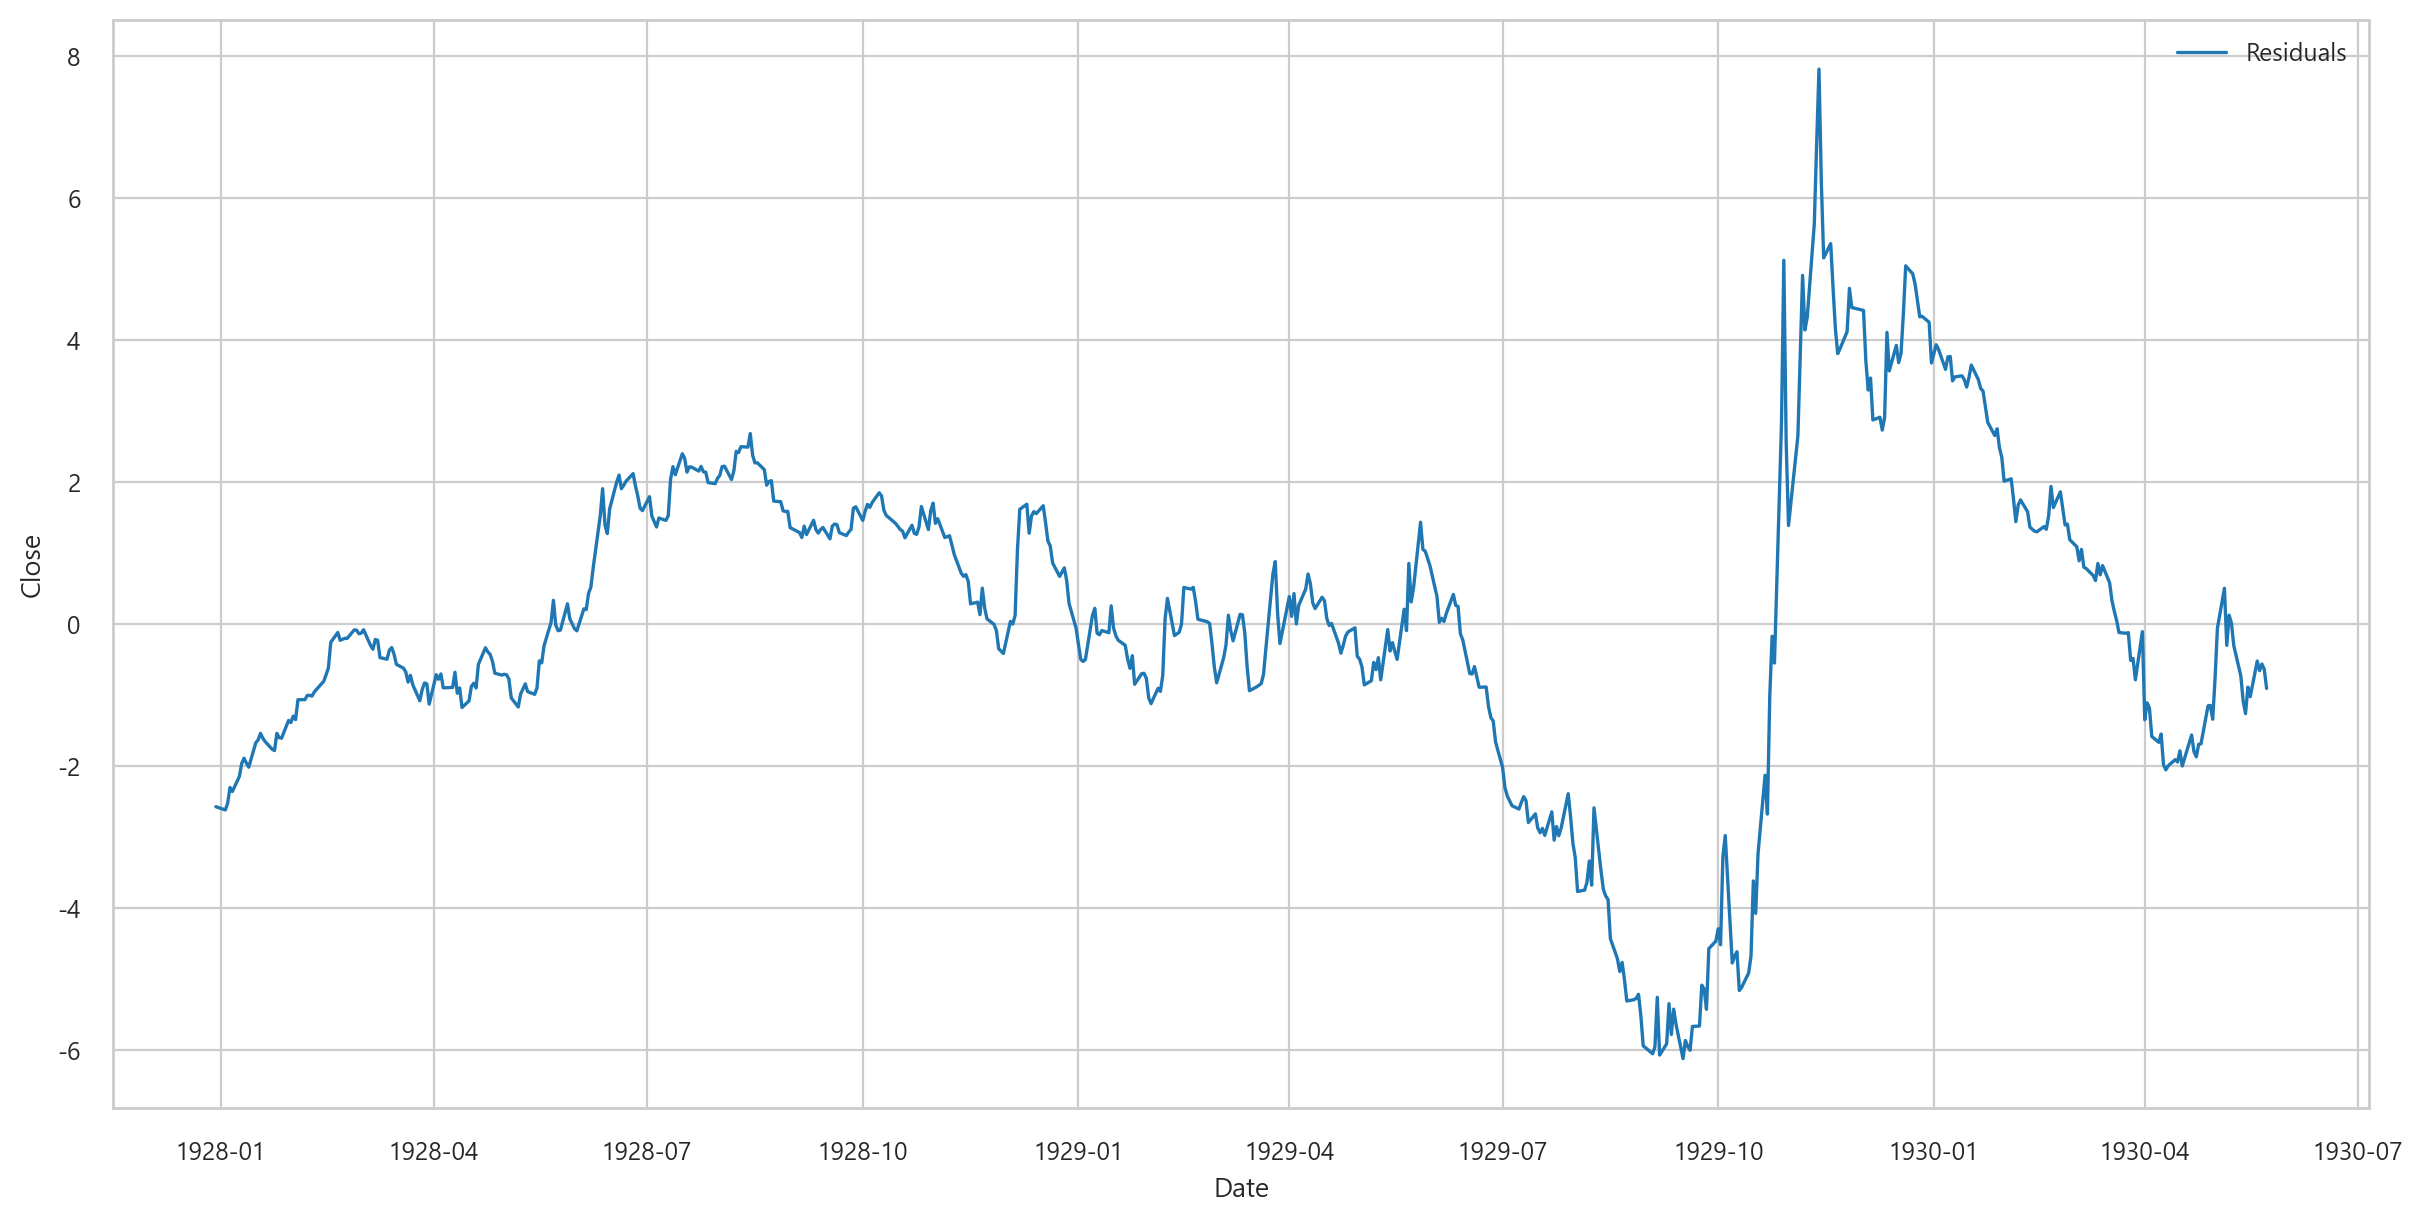

In [427]:
resid = pd.DataFrame(data = pred_train.values,index = pred_train.index,columns= ["Close"])\
    - y_train

fig, ax = plt.subplots(1,1, figsize=(12,6))


sns.lineplot(data=resid,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="Residuals",);

In [428]:
resid.rename(columns={"Close":"resid"}, inplace=True)

In [429]:
model_3 = DecisionTreeRegressor()
model_3.fit(x_train.values,resid[["resid"]])
pred_test_3 = model_3.predict(pd.DataFrame(data=pred_test_2,index=y_test.index,columns=["Close"]) - y_test)
pred_train_3 = model_3.predict(pd.DataFrame(data=pred_train,index=y_train.index,columns=["Close"]) - y_train)

c:\Users\crazy\miniconda3\envs\kdt\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


ValueError: X has 1 features, but DecisionTreeRegressor is expecting 3 features as input.

In [ ]:
final_pred_train = pred_train - pred_train_3
final_pred_test = pred_test - pred_test_3

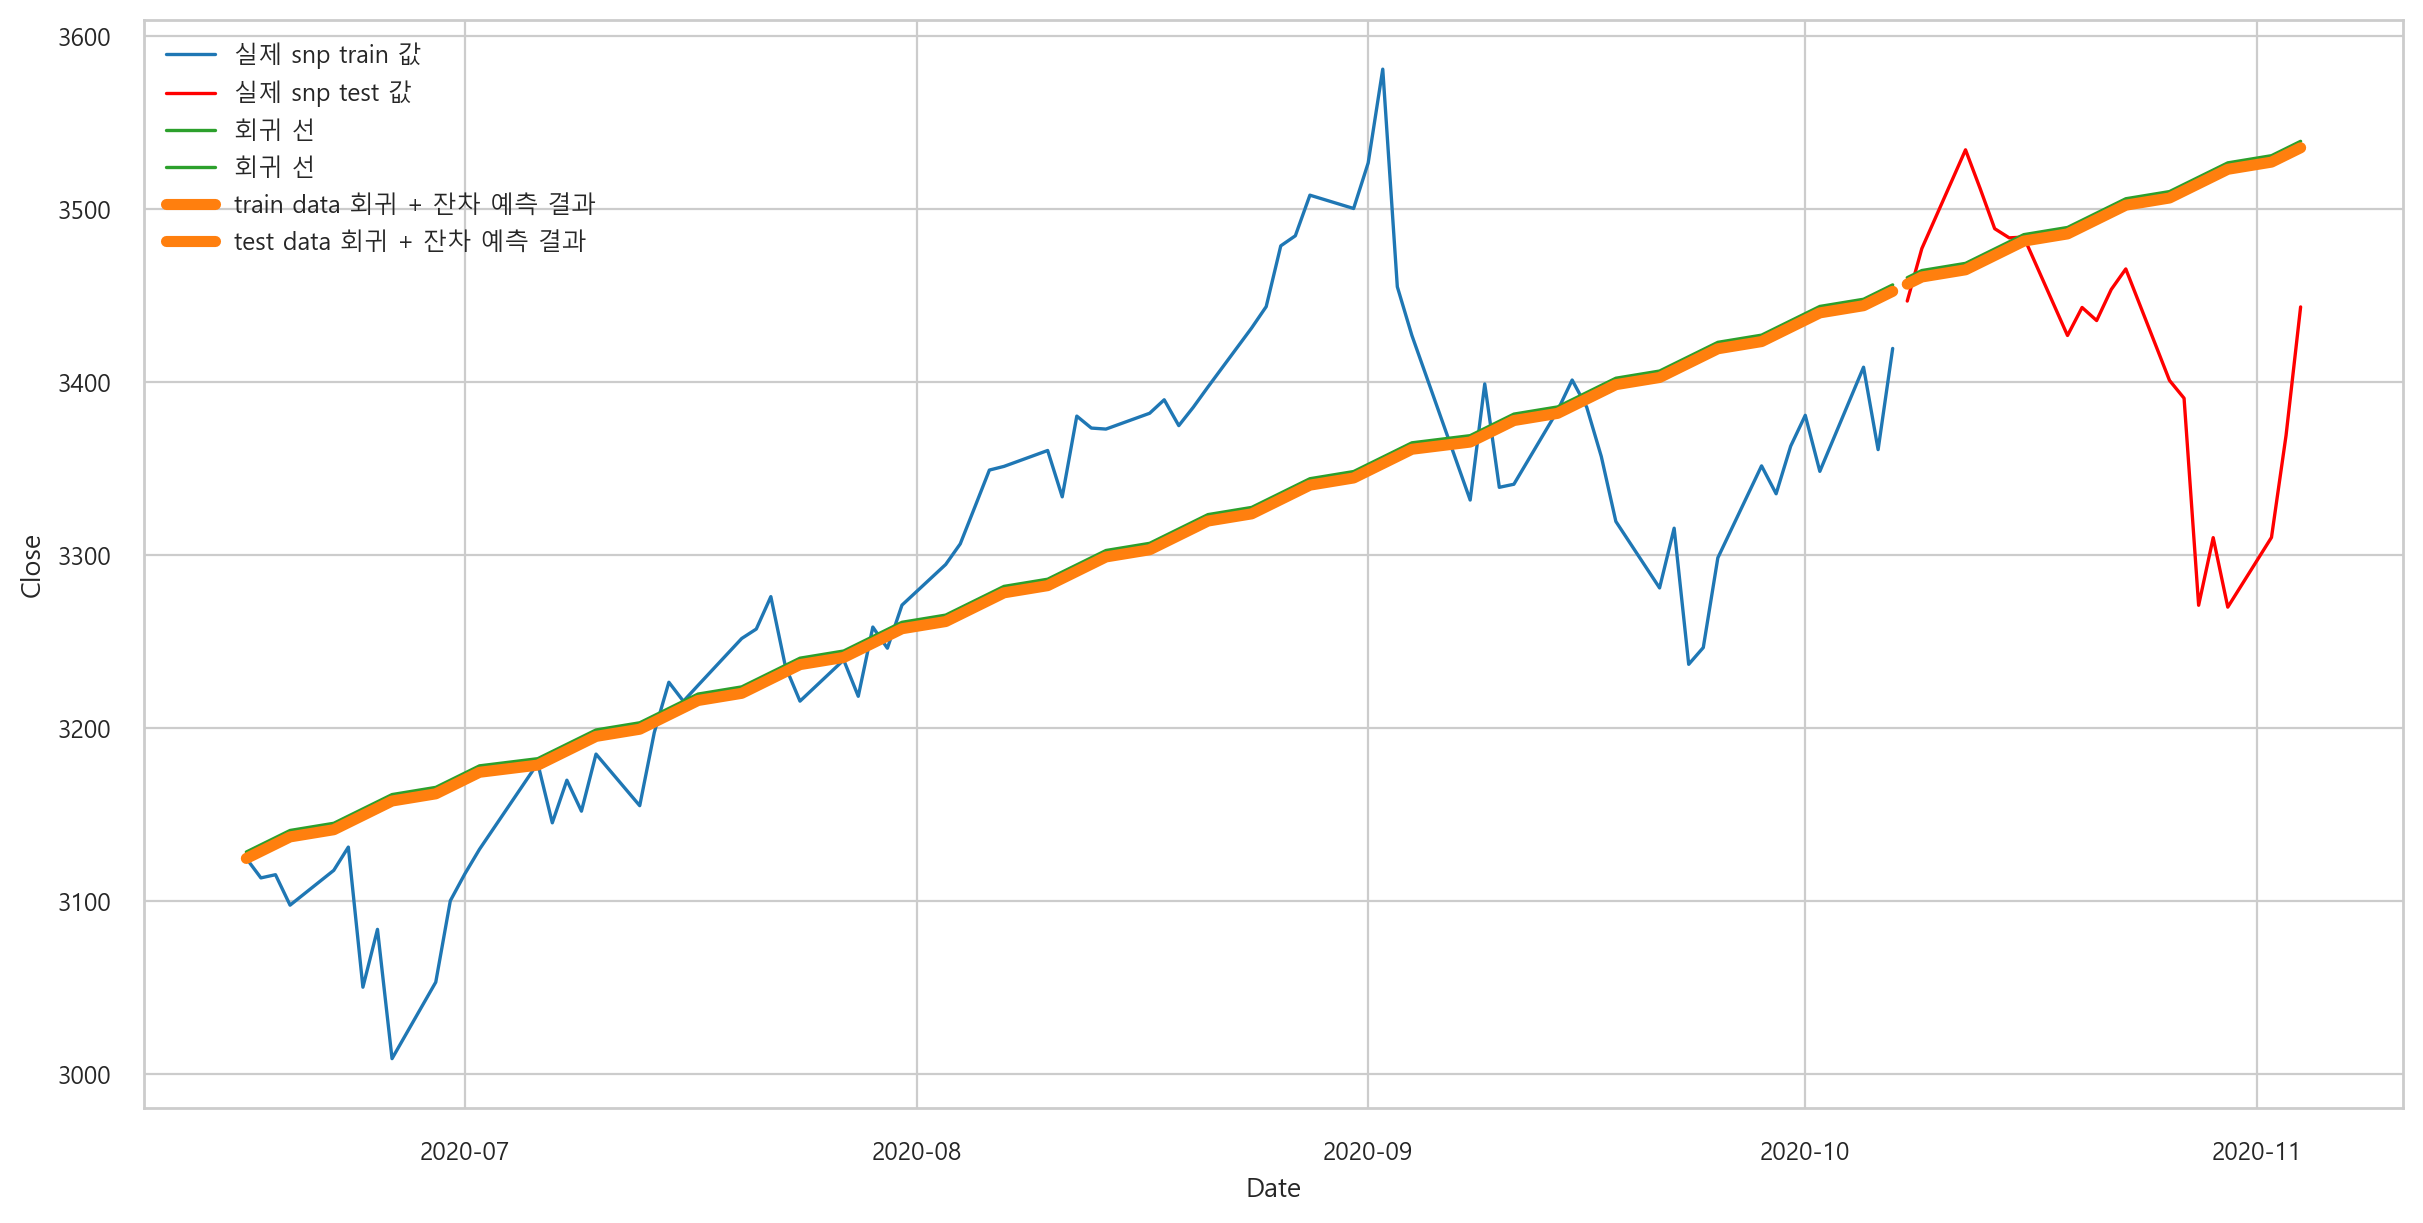

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6))


sns.lineplot(data=y_train,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="실제 snp train 값",)

sns.lineplot(data=y_test,
             x = "Date",
             y = "Close",
             color="red",
             label="실제 snp test 값",)

sns.lineplot(x=y_train.index,
             y=pred_train,
             color="tab:green",
             label="회귀 선",)

sns.lineplot(x=y_test.index,
             y=pred_test,
             color="tab:green",
             label="회귀 선",)

sns.lineplot(x=y_train.index,
             y=final_pred_train,
             color="tab:orange",
             linewidth=4,
             label="train data 회귀 + 잔차 예측 결과",);

sns.lineplot(x=y_test.index,
             y=final_pred_test,
             color="tab:orange",
             linewidth=4,
             label="test data 회귀 + 잔차 예측 결과",);

In [ ]:
# 데이터 불러오기
snp_500 = pd.read_csv('../selfstudy/study_data/snp500_history.csv',
                      parse_dates=['Date']).tail(300)
close_snp = snp_500[["Date","Close"]].copy()

# 1. 지연 피쳐 만들기
close_snp["Lag"]=  close_snp["Close"].shift(1)

# 2. 이동 평균
close_snp["moving_mean"]=close_snp["Close"].rolling(window=5,center=False).mean()

# 3. Serial Dependence
close_snp["index"] = close_snp.index - close_snp.index.min() - 2 # 결측치를 없애기 위함

close_snp.index = close_snp["Date"]
close_snp.drop(columns=["Date"], inplace=True)
close_snp_prep = close_snp.dropna(axis=0)


In [ ]:
X = close_snp_prep.drop(columns=["Close"])
y = close_snp_prep[["Close"]]

x_train, x_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 30,
                                                    random_state = 42,
                                                    shuffle=False)

In [ ]:
# 테스트 데이터의 lag, moving_mean 을 모른다는 가정하에 우선 lag 훈련 시키기
# 입력값 index, 라벨 값 = lag
lag_regress = LinearRegression()
lag_regress.fit(x_train[["index"]],x_train[["Lag"]])
lag_pred_test = lag_regress.predict(x_test[["index"]])


In [ ]:
x_test["Lag"] = pd.DataFrame(data=lag_pred_test.flatten(),index=x_test.index,columns=["Lag"])
x_test

,Lag,moving_mean,index
Date,,,
2020-09-24,3199.321917,3279.922022,268
2020-09-25,3200.172048,3275.720020,269
2020-09-28,3201.022179,3289.828027,270
2020-09-29,3201.872309,3293.808008,271
2020-09-30,3202.722440,3319.024024,272
2020-10-01,3203.572571,3345.866016,273
2020-10-02,3204.422702,3355.858008,274
2020-10-05,3205.272833,3367.258008,275
2020-10-06,3206.122964,3372.358008,276


In [ ]:
x_test["moving_mean"] = x_test["Lag"].rolling(window=5, center=False).mean()
x_test.dropna(axis=0, inplace=True)

In [ ]:
x_test

,Lag,moving_mean,index
Date,,,
2020-09-30,3202.722440,3201.022179,272
2020-10-01,3203.572571,3201.872309,273
2020-10-02,3204.422702,3202.722440,274
2020-10-05,3205.272833,3203.572571,275
2020-10-06,3206.122964,3204.422702,276
2020-10-07,3206.973095,3205.272833,277
2020-10-08,3207.823226,3206.122964,278
2020-10-09,3208.673357,3206.973095,279
2020-10-12,3209.523488,3207.823226,280


In [ ]:
# 예측한 지연 피쳐에 대한이동 평균 계산


In [ ]:
model_final_1 = LinearRegression()
model_final_1.fit(x_train, y_train)
pred_train_final_1 = model_final_1.predict(x_train)
pred_test_final_1 = model_final_1.predict(x_test)

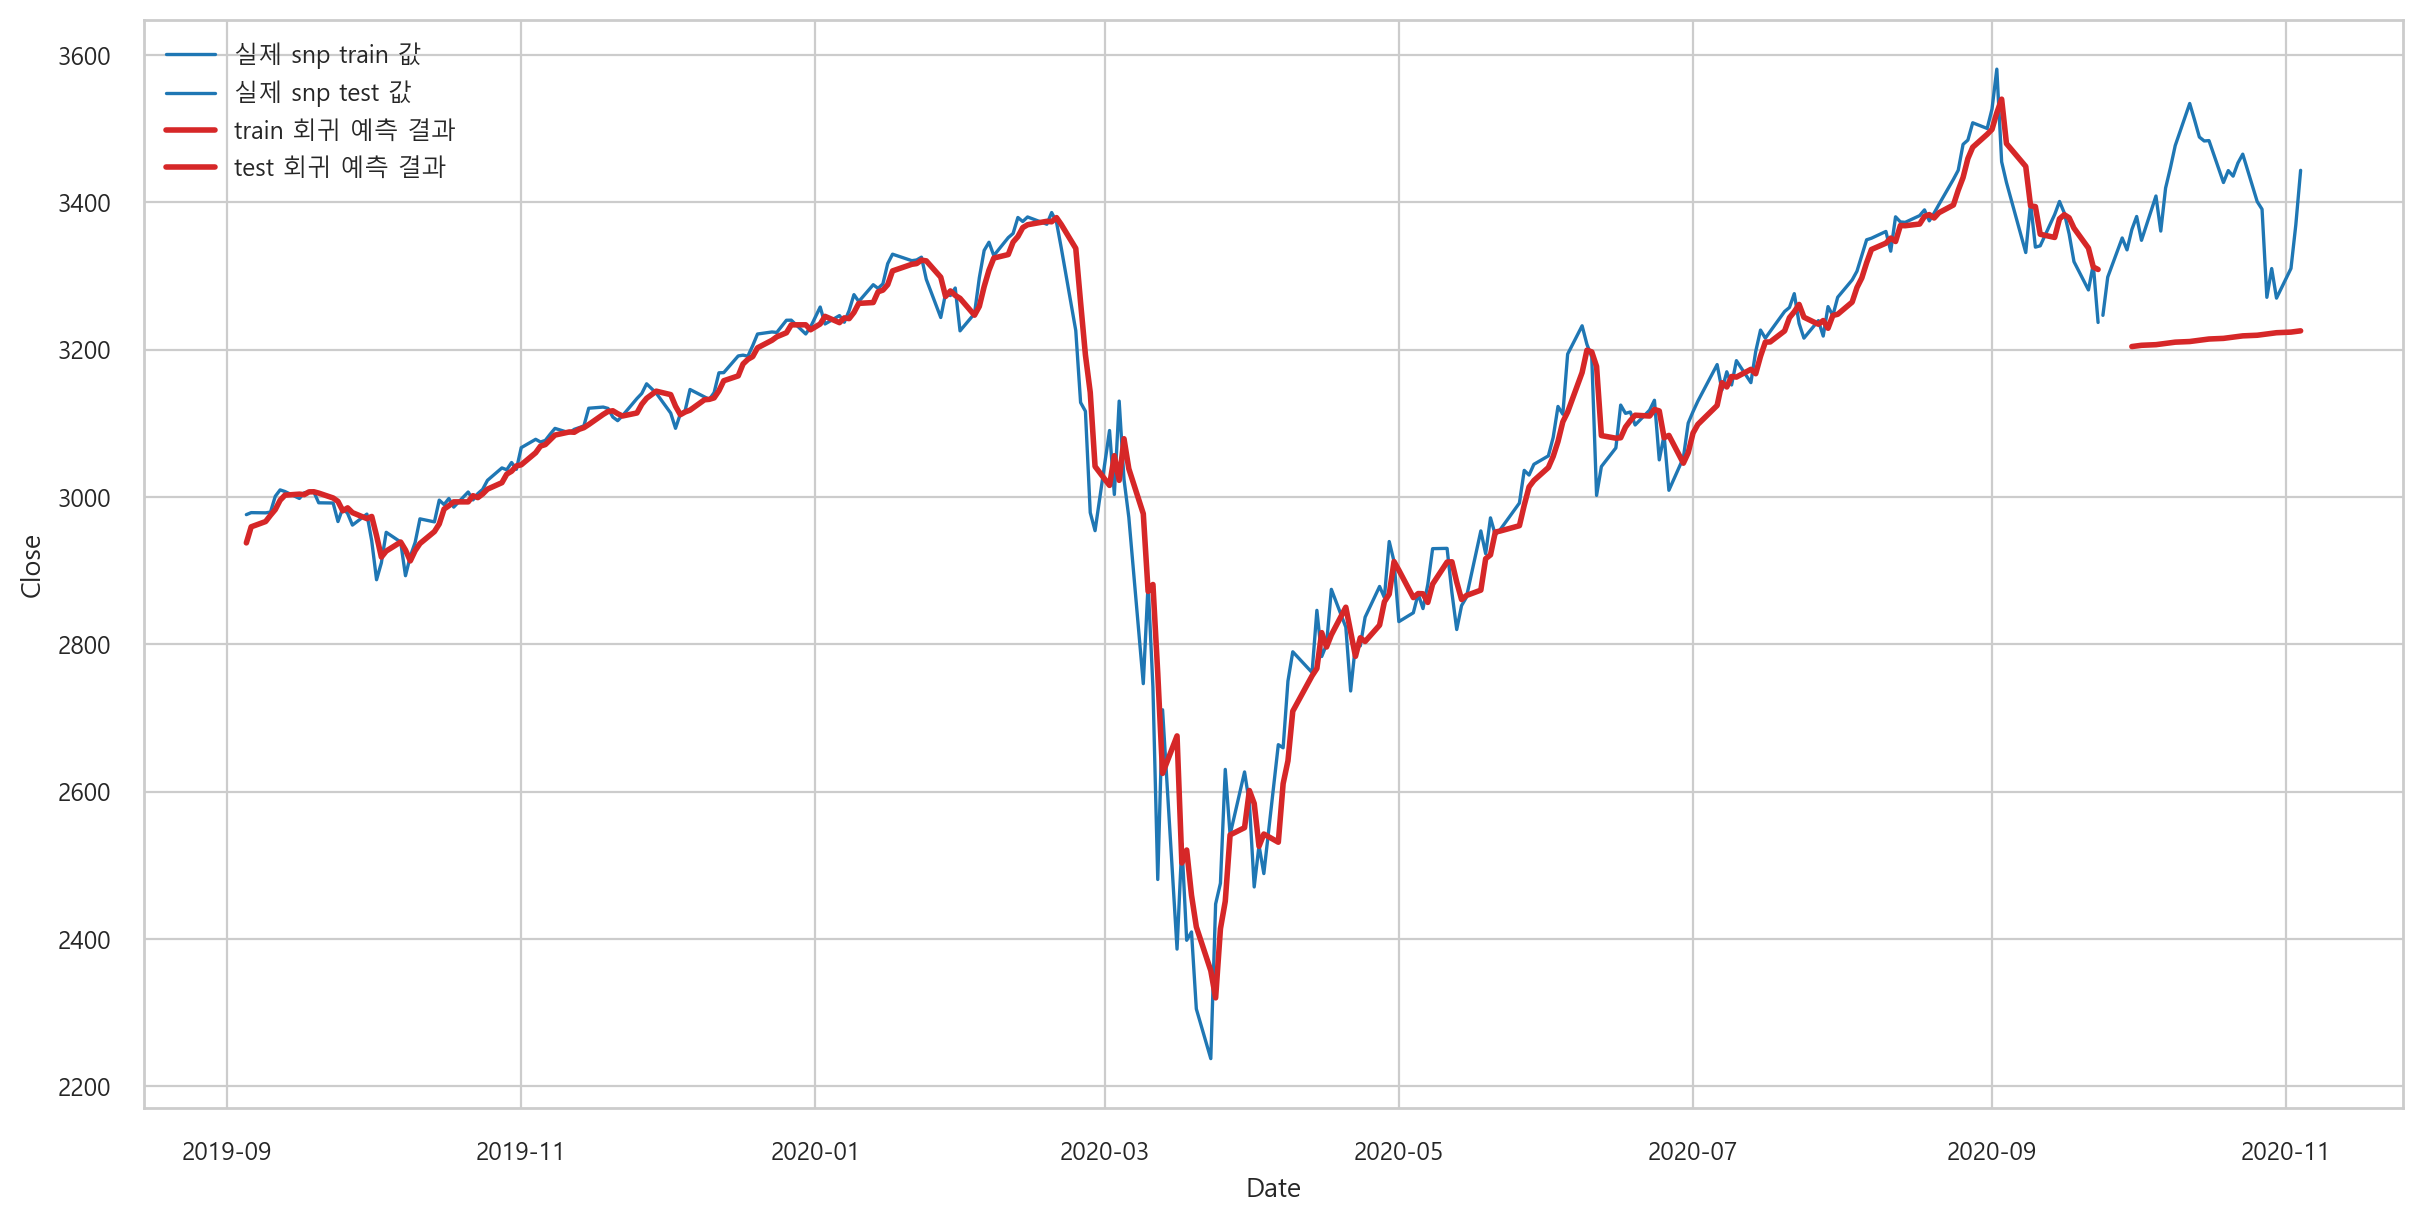

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6))


sns.lineplot(data=y_train,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="실제 snp train 값",)

sns.lineplot(data=y_test,
             x = "Date",
             y = "Close",
             color="tab:blue",
             label="실제 snp test 값",)

sns.lineplot(x=y_train.index,
             y=pred_train_final_1.flatten(),
             color="tab:red",
             linewidth=2,
             label="train 회귀 예측 결과",);

sns.lineplot(x=x_test.index,
             y=pred_test_final_1.flatten(),
             color="tab:red",
             linewidth=2,
             label="test 회귀 예측 결과",);